# Prolific study evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

In [14]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

display(df_raw.head())
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
0,78f2fd02-b50f-4c85-83f4-d06096a2a8c0,DEBUG,debug_profile,completed,2025-12-30T18:48:19.397257+00:00,"[{'rt': 1414, 'exit_time': 1767120498908, 'pro...",1767120498908,1767120475173,-1
1,6a52faf5-16be-40ed-9473-6ea0e02bf53f,DEBUG,debug_profile,completed,2025-12-30T19:30:51.544457+00:00,"[{'rt': 1409, 'exit_time': 1767123050529, 'pro...",1767123050529,1767123026955,-1
2,59ff4bcd-653b-4682-8396-580955516b7e,TEST_1d0e4153-c4e9-44c0-8ef2-7e18a66ae979,profile_25_first,completed,2025-12-30T19:36:50.817149+00:00,"[{'rt': 1125, 'exit_time': 1767123407781, 'tim...",1767123407781,1767123156882,34
3,470d91eb-0351-4747-b694-518034c2a015,DEBUG,debug_profile,completed,2025-12-30T20:02:00.778582+00:00,"[{'rt': 822, 'exit_time': 1767124919569, 'time...",1767124919569,1767124884483,-1
4,36e6c355-79cd-4fa3-b731-ba53a25e9bf0,TEST_4094a6c0-f96f-498d-9e05-7b4f1c0ef206,profile_32_last,failed_distractor,2025-12-30T20:25:33.516265+00:00,"[{'rt': 1842, 'exit_time': 1767126332543, 'tim...",1767126332543,1767126207820,51


(53, 9)


In [34]:
# Explode df_raw into trial-level df 
import pandas as pd

rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)


# Normalize and clean columns
bool_cols = [
    "passed",
    "is_distractor",
    "timed_out",
]

for col in bool_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype("boolean") 
            .fillna(False)
            .astype(bool)
        )

# Distractor errors
if "distractor_errors" in df.columns:
    df["distractor_errors"] = (
        df["distractor_errors"]
        .fillna(0)
        .astype(int)
    )

# Certainty: numeric where present, NaN else
if "certainty" in df.columns:
    df["certainty"] = pd.to_numeric(df["certainty"], errors="coerce")

# Reaction time: force numeric
df["rt"] = pd.to_numeric(df["rt"], errors="coerce")


# Accuracy 
# Trials with a correct answer
df["has_correct_answer"] = df["correct_response"].notna()

# Accuracy is only meaningful for those trials
df["is_correct"] = (
    df["response_index"] == df["correct_response"]
).where(df["has_correct_answer"], None)

df["is_color_task"] = df["task_type"].eq("color_judgment")
df["is_sanity_task"] = df["task_type"].eq("sanity")

display(df.head(10))
print("Shape:", df.shape)
print("\nBoolean dtypes:")
print(df[bool_cols].dtypes)


,PROLIFIC_PID,profile_id,exit_reason,rt,exit_time,subject_id,trial_type,trial_index,time_elapsed,view_history,...,slider_start,timed_out,timeout_time,image_path,distractor_errors,certainty,has_correct_answer,is_correct,is_color_task,is_sanity_task
0,DEBUG,debug_profile,completed,1414.0,1767120498908,DEBUG,instructions,0,1439,"[{'page_index': 0, 'viewing_time': 1413}]",...,NaN,False,NaN,NaN,0,NaN,False,None,False,False
1,DEBUG,debug_profile,completed,1437.0,1767120498908,DEBUG,html-button-response,1,2883,NaN,...,NaN,False,NaN,NaN,0,NaN,False,None,True,False
2,DEBUG,debug_profile,completed,1765.0,1767120498908,DEBUG,html-button-response,2,4659,NaN,...,NaN,False,NaN,NaN,0,NaN,False,None,True,False
3,DEBUG,debug_profile,completed,3127.0,1767120498908,DEBUG,survey-likert,3,7788,NaN,...,NaN,False,NaN,NaN,0,NaN,True,False,False,True
4,DEBUG,debug_profile,completed,1456.0,1767120498908,DEBUG,html-button-response,4,9251,NaN,...,NaN,False,NaN,NaN,0,NaN,False,None,True,False
5,DEBUG,debug_profile,completed,4412.0,1767120498908,DEBUG,survey-text,5,13692,NaN,...,NaN,False,NaN,NaN,0,NaN,True,False,False,True
6,DEBUG,debug_profile,completed,1464.0,1767120498908,DEBUG,html-button-response,6,15161,NaN,...,NaN,False,NaN,NaN,0,NaN,False,None,True,False
7,DEBUG,debug_profile,completed,1632.0,1767120498908,DEBUG,survey-likert,7,16797,NaN,...,NaN,False,NaN,NaN,0,NaN,True,False,False,True
8,DEBUG,debug_profile,completed,1551.0,1767120498908,DEBUG,html-button-response,8,18352,NaN,...,NaN,False,NaN,NaN,0,NaN,False,None,True,False
9,DEBUG,debug_profile,completed,2826.0,1767120498908,DEBUG,survey-likert,9,21181,NaN,...,NaN,False,NaN,NaN,0,NaN,True,False,False,True


Shape: (3042, 38)

Boolean dtypes:
passed           bool
is_distractor    bool
timed_out        bool
dtype: object


In [35]:
df["view_history"].notna().sum()

np.int64(53)

In [36]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    2745
sanity             161
introspection       52
warning             31
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            26
failed_distractor    21
failed_attention      6
Name: count, dtype: int64


In [37]:
# Extract only valid color judgments for analysis)
df_color = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed")
].copy()

len(df_color)

2315

In [38]:
trials_per_pid = df.groupby("PROLIFIC_PID").size()

trials_per_pid.describe()


count     25.000000
mean     121.680000
std       50.518742
min       36.000000
25%      107.000000
50%      107.000000
75%      108.000000
max      264.000000
dtype: float64

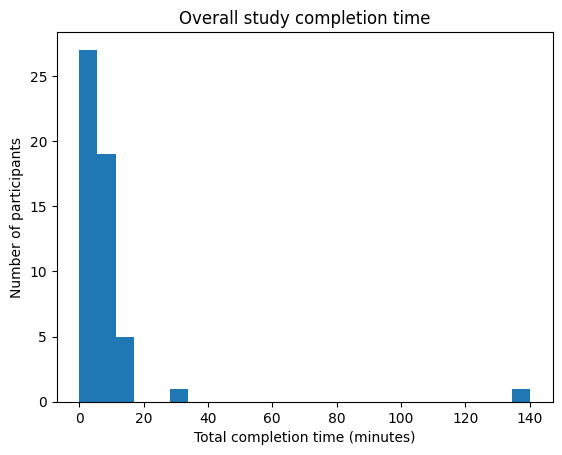

In [39]:
# Participant-level completion time (minutes)

df_raw['experiment_start_time'] = pd.to_datetime(
    df_raw['experiment_start_time'], unit='ms'
)
df_raw['exit_time'] = pd.to_datetime(
    df_raw['exit_time'], unit='ms'
)

df_raw['total_time_min'] = (
    df_raw['exit_time'] - df_raw['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_raw['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.show()

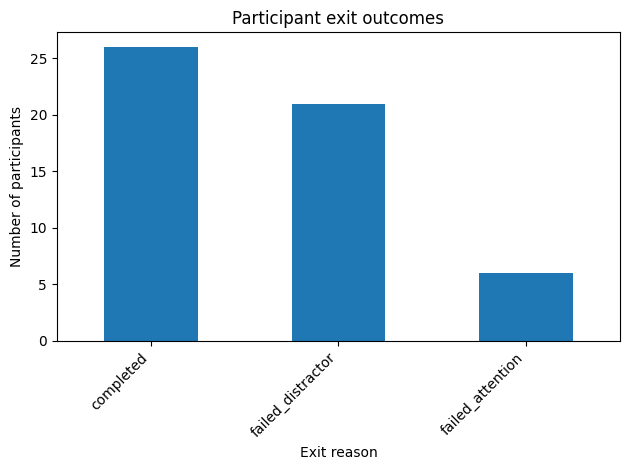

In [40]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure()
exit_counts.plot(kind='bar')
plt.xlabel('Exit reason')
plt.ylabel('Number of participants')
plt.title('Participant exit outcomes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

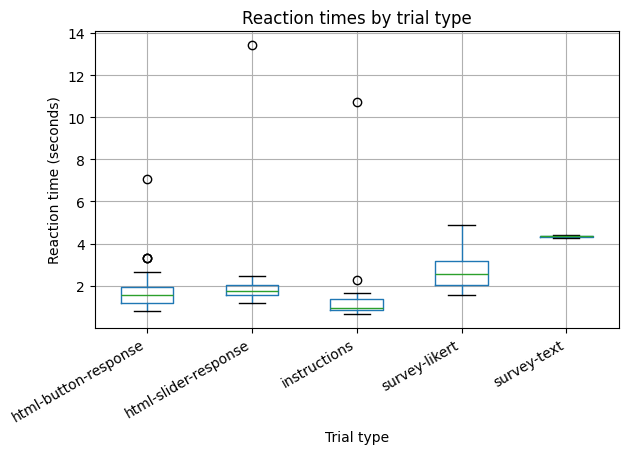

In [46]:
# Trial-level reaction times (seconds)
# Filter valid RTs
df_rt = df[(~df['timed_out']) & (df['rt'].notna())].copy()

# Convert ms → seconds
df_rt['rt_sec'] = df_rt['rt'] / 1000

plt.figure(figsize=(8, 5))
df_rt.boxplot(column='rt_sec', by='trial_type')

plt.ylabel('Reaction time (seconds)')
plt.xlabel('Trial type')
plt.title('Reaction times by trial type')
plt.suptitle('')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


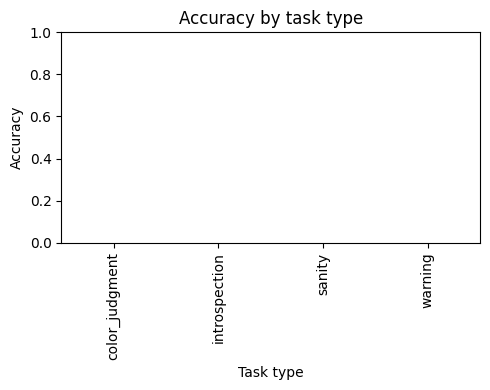

In [ ]:
# Cell 4: Accuracy by task type

df_scored = df[df['is_correct'].notna()].copy()

# Convert True/False -> 1/0
df_scored['is_correct_num'] = df_scored['is_correct'].astype(int)

accuracy_by_task = (
    df_scored
    .groupby('task_type')['is_correct_num']
    .mean()
    .sort_values()
)

plt.figure(figsize=(5, 4))
accuracy_by_task.plot(kind='bar')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Task type')
plt.title('Accuracy by task type')
plt.tight_layout()
plt.show()


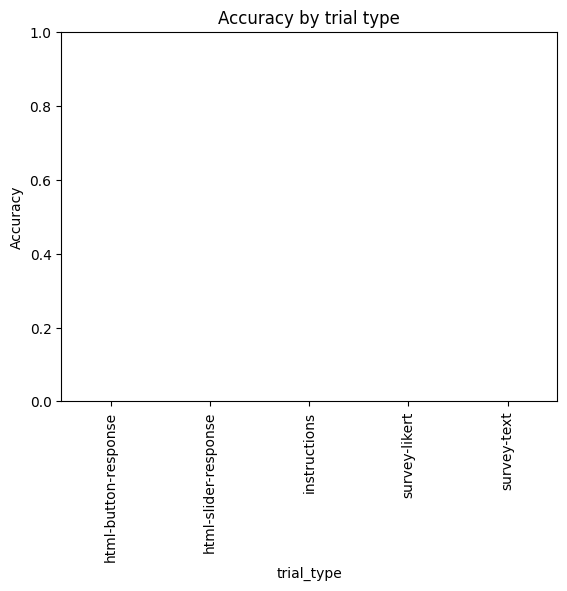

In [ ]:
#Color–concept entanglement proxy
# Interesting angle: does accuracy drop when distractor errors increase?

plt.figure()
plt.scatter(df['distractor_errors'], df['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Number of distractor errors')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Accuracy vs distractor interference')
plt.show()

#Certainty vs correctness

certainty_stats = (
    df.groupby('is_correct')['certainty']
      .mean()
)

plt.figure()
certainty_stats.plot(kind='bar')
plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
plt.ylabel('Mean certainty')
plt.title('Metacognition: certainty tracks correctness')
plt.show()

# Learning or fatigue over time

# Order trials within participant

df_sorted = df.sort_values(['PROLIFIC_PID', 'trial_index'])
df_sorted['rolling_accuracy'] = (
    df_sorted.groupby('PROLIFIC_PID')['is_correct']
             .rolling(window=10, min_periods=5)
             .mean()
             .reset_index(level=0, drop=True)
)

plt.figure()
plt.plot(df_sorted['rolling_accuracy'], alpha=0.5)
plt.ylim(0, 1)
plt.ylabel('Rolling accuracy')
plt.xlabel('Trial (within participant)')
plt.title('Learning / fatigue effects over trials')
plt.show()

# Speed–accuracy tradeoff 

plt.figure()
plt.scatter(df_rt['rt'], df_rt['is_correct'].astype(int), alpha=0.2)
plt.xlabel('Reaction time (ms)')
plt.ylabel('Correct (1=yes, 0=no)')
plt.title('Speed–accuracy tradeoff')
plt.show()

#  Flag suspicious participants

participant_stats = (
    df.groupby('PROLIFIC_PID')
      .agg(
          mean_rt=('rt', 'mean'),
          accuracy=('is_correct', 'mean'),
          n_trials=('trial_index', 'count')
      )
)

fast_rt_threshold = participant_stats['mean_rt'].quantile(0.05)
low_acc_threshold = 0.55

suspicious = participant_stats[
    (participant_stats['mean_rt'] < fast_rt_threshold) |
    (participant_stats['accuracy'] < low_acc_threshold)
]

print(f"Flagged participants: {len(suspicious)}")
suspicious.head()
